## Setup

In [1]:
#setup

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
import MDAnalysis as mda
import natsort
from glob import glob
from tqdm.notebook import tqdm

plt.rcParams.update({
"font.size": 12,
"text.usetex": False,
"mathtext.fontset": "stixsans"
})

root="/scratch/project_465000467/FABIO/Anesthetics"


colors = {"Chloroform,C8,1.2":"xkcd:raspberry","Chloroform,C18,1.2":"xkcd:raspberry",
          "Ethylene,C8,1.2":"xkcd:mid blue","Ethylene,C18,1.2":"xkcd:mid blue",
          "Diethyl_ether,C8,1.2":"xkcd:algae green","Diethyl_ether,C18,1.2":"xkcd:algae green",
          "None,C8,1.2":"xkcd:pumpkin orange","None,C18,1.2":"xkcd:pumpkin orange"}

In [2]:
#functions
def write_topol(fname,sysname,mols,includes,mode):
    fout = open(fname,mode)
    for i in includes:
        fout.write("%s\n" % i)
    if sysname:
        fout.write("\n[ system ]\n%s" % sysname)
        fout.write("\n\n[ molecules ]\n")
    if mols:
        for i in mols:      
            fout.write("%5s%10d\n" % (i[0],i[1]))
    fout.close()
    return

def write_gro_and_topol(root,sys,pis,bulk,pis1,tw,sw,w):

    fname = f"{root}/Runs/{sys}/0MPa.top"
    mols = [("PIS",pis.n_atoms),("BULK",bulk.n_atoms),("PIS1",pis1.n_atoms),("TW",tw.n_atoms),("SW",sw.n_atoms),(("W",w.n_atoms))]
    includes = ['#include "martini_v3.0.0_N1Lay.itp"',
    '#include "martini_v3.0.0_solvents_v1.itp"',
    '#include "lay1-sil.itp"',
    '#include "surf.itp"']
    write_topol(fname,"system",mols,includes,"w")

    x,y,z = pis.positions[:,0]*.1,pis.positions[:,1]*.1,pis.positions[:,2]*.1
    pis = pd.DataFrame({"resname":["PIS"]*len(x),"atomname":["C1"]*len(x),"x":x,"y":y,"z":z})

    x,y,z = bulk.positions[:,0]*.1,bulk.positions[:,1]*.1,bulk.positions[:,2]*.1
    bulk = pd.DataFrame({"resname":["BULK"]*len(x),"atomname":["N1B"]*len(x),"x":x,"y":y,"z":z})

    x,y,z = tw.positions[:,0]*.1,tw.positions[:,1]*.1,tw.positions[:,2]*.1
    tw = pd.DataFrame({"resname":["TW"]*len(x),"atomname":["TW"]*len(x),"x":x,"y":y,"z":z})

    x,y,z = sw.positions[:,0]*.1,sw.positions[:,1]*.1,sw.positions[:,2]*.1
    sw = pd.DataFrame({"resname":["SW"]*len(x),"atomname":["SW"]*len(x),"x":x,"y":y,"z":z})

    x,y,z = w.positions[:,0]*.1,w.positions[:,1]*.1,w.positions[:,2]*.1
    w = pd.DataFrame({"resname":["W"]*len(x),"atomname":["W"]*len(x),"x":x,"y":y,"z":z})

    x,y,z = pis1.positions[:,0]*.1,pis1.positions[:,1]*.1,pis1.positions[:,2]*.1
    pis1 = pd.DataFrame({"resname":["PIS1"]*len(x),"atomname":["C1"]*len(x),"x":x,"y":y,"z":z})

    df = pd.concat([pis,bulk,pis1,tw,sw,w])

    fname = f"{root}/Runs/{sys}/0MPa.gro"
    write_gro(fname,"w",df)

def write_gro(fname,mode,df,num=None,name="System"):
    df = df.reset_index()
    fout = open(fname,mode)
    fout.write(f"{name}\n")
    fout.write(f" {int(len(df))}\n")
    
    i,j = 0,0
    for i, row in df.iterrows():
        if i == 99999 or j == 99998:
            j = 0
        elif i < 99999:
            j = i
        else:
            j = j+1

        if num:
            idx = num
        else:
            idx = int(j+1)
            
        fout.write("%5d%-5s%5s%5d%8.3f%8.3f%8.3f\n" % (idx, str(row["resname"]), str(row["atomname"]), int(j+1), float(row["x"]), float(row["y"]), float(row["z"])))
    fout.write("  %.8f %.8f %.8f" % (df["x"].max()-df["x"].min(),df["y"].max()-df["y"].min(),df["z"].max()-df["z"].min()))
    fout.close()
    return

def get_values(pressures,folder,frames_from_last):

    if frames_from_last:
        print(f"Using last {frames_from_last} frames")
        frames_from_last = -frames_from_last
    else:
        print(f"Using all frames")
        frames_from_last=0

    fill = []
    for press in tqdm(pressures):    
        if press < 0:
            pressname="neg"+str(press)[1:]
        elif press == 0.0:
            pressname=0
        else:
            pressname=press

        try:
            filename = glob.glob(f"{folder}/{pressname}MPa/{pressname}MPa.**.part**.gro")[0]
            trajname = glob.glob(f"{folder}/{pressname}MPa/{pressname}MPa.**.part**.xtc")[0]    
        except:
            continue
        
        u = mda.Universe(filename,trajname)

        cyl = u.select_atoms("resname BULK")
        pis, pis1 = u.select_atoms("resname PIS"), u.select_atoms("resname PIS1")
        water_system = u.select_atoms("resname W or resname SW or resname TW")
        zmin, zmax = np.min(cyl.positions[:,2]), np.max(cyl.positions[:,2])
        water_inside = water_system.select_atoms(f"prop z >= {zmin} and prop z <= {zmax}", updating=True)

        water_list = []
        tjs= u.trajectory[frames_from_last:]
        for ts in tjs:        
            n_water = water_inside.n_atoms
            water_list.append(n_water)
            
        mean = np.mean(water_list)
        std = np.std(water_list)
        fill.append((press,mean,std))
    return np.array(fill)

def stilyze_plot(fig,xlab,ylab,invis=None):

    if len(fig.axes) > 1:
        for ax in fig.axes:
            ax.tick_params(which='minor', length=3, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
            ax.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
            
        ax_label = fig.add_subplot(111, frameon=False)
        ax_label.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax_label.grid(False)

        ax_label.set_ylabel(ylab,size=14)
        ax_label.set_xlabel(xlab,size=14)
    else:
        axis = fig.axes[0]
        axis.set_ylabel(ylab,size=14)
        axis.set_xlabel(xlab,size=14)
        axis.tick_params(which='minor', length=3, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
        axis.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)
    
    if invis:
        for v,ax in zip(invis,fig.axes):
            for vv in v:
                ax.spines[vv].set_visible(False)
    return


/scratch/project_465000467/FABIO/Anesthetics/Nitrogen/C18,1.2/100/eq/Cycle1/extrusion/0MPa/0MPa.1.part0001.gro


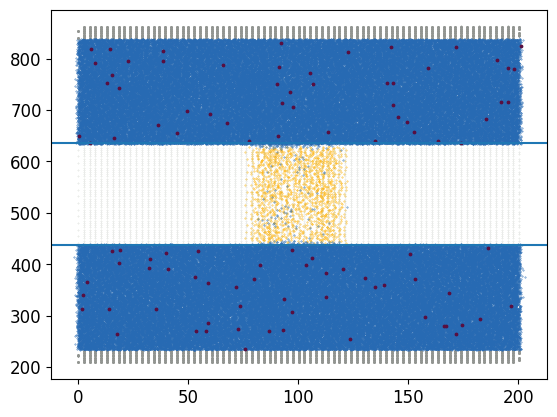

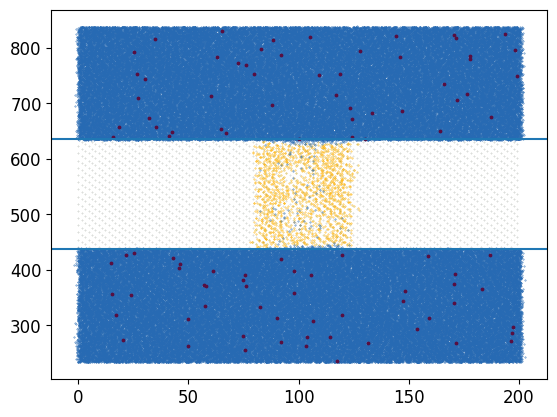

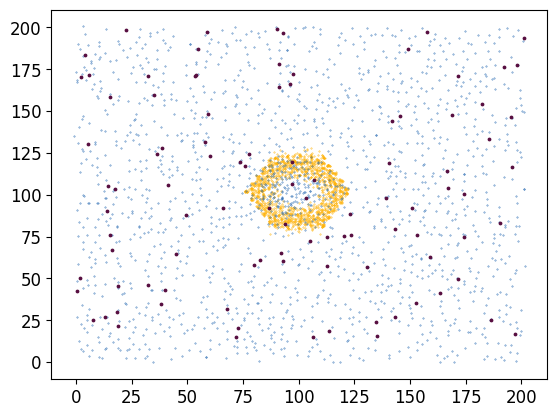

In [10]:
#plot configuration

mol = "Nitrogen"
sys = "C18,1.2"
run = "eq"
cycle = "Cycle1"
ngas = 100
press = "0"
ie = "extrusion"
root="/scratch/project_465000467/FABIO/Anesthetics"

#files = glob(f"{root}/{mol}/{sys}/{ngas}/{run}/start_gased/minimized.gro")
files = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/{ie}/{press}MPa/{press}MPa**.gro"))
filename = files[-1]
print(filename)

u = mda.Universe(filename)
silanes = u.select_atoms("resname SIL")
bulk_x = u.select_atoms("resname BULK or resname LAY or resname SI and prop x < 90")
bulk_y = u.select_atoms("resname BULK or resname LAY or resname SI and prop y < 90")
bulk = u.select_atoms("resname BULK or resname LAY or resname SI")
zmin, zmax = bulk.positions[:,2].min(), bulk.positions[:,2].max()

solv = u.select_atoms("resname W or resname SW or resname TW or name R1 or name R2 or name R3 or resname OCT")
solv_z = u.select_atoms(f"name W or name SW or name TW or name R1 or name R2 or name R3 or resname OCT and prop z > {zmin} and prop z < {zmax}")
gas = u.select_atoms("resname CLF or resname ETY or resname ETH or resname NI2")

solv1 = u.select_atoms(f"resname W or resname SW or resname TW or name R1 or name R2 or name R3 or resname OCT and prop z < {zmin}")
solv2 = u.select_atoms(f"resname W or resname SW or resname TW or name R1 or name R2 or name R3 or resname OCT and prop z > {zmax}")

w = u.select_atoms("resname W")
tw = u.select_atoms("resname TW")
sw = u.select_atoms("resname SW")

pis = u.select_atoms("resname PIS")
pis1  = u.select_atoms("resname PIS1")

x1,y1,z1 = solv1.positions[:,0],solv1.positions[:,1],solv1.positions[:,2]
lx1,ly1,lz1 = np.max(x1)-np.min(x1), np.max(y1)-np.min(y1), np.max(z1)-np.min(z1)
x2,y2,z2 = solv2.positions[:,0],solv2.positions[:,1],solv2.positions[:,2]
lx2,ly2,lz2 = np.max(x2)-np.min(x2), np.max(y2)-np.min(y2), np.max(z2)-np.min(z2)
v1 = lx1*ly1*lz1
v2 = lx2*ly2*lz2

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()

ax1.scatter(pis.positions[:,0],pis.positions[:,2],s=0.1, c="xkcd:gray", alpha=1)
ax1.scatter(pis1.positions[:,0],pis1.positions[:,2],s=0.1, c="xkcd:gray", alpha=1)

ax1.scatter(silanes.positions[:,0],silanes.positions[:,2],s=0.1, c="xkcd:amber", alpha=1)
ax2.scatter(silanes.positions[:,1],silanes.positions[:,2],s=0.1, c="xkcd:amber", alpha=1)
ax3.scatter(silanes.positions[:,0],silanes.positions[:,1],s=0.1, c="xkcd:amber", alpha=1)

ax1.scatter(bulk_y.positions[:,0],bulk_y.positions[:,2],s=0.01, c="xkcd:light gray", alpha=0.2)
ax2.scatter(bulk_x.positions[:,1],bulk_x.positions[:,2],s=0.01, c="xkcd:light gray", alpha=0.2)
#ax3.scatter(bulk.positions[:,0],bulk.positions[:,1],s=0.1, c="xkcd:gray", alpha=0.2)

ax1.scatter(solv.positions[:,0],solv.positions[:,2],s=0.1, c="xkcd:mid blue", alpha=1)
ax2.scatter(solv.positions[:,1],solv.positions[:,2],s=0.1, c="xkcd:mid blue", alpha=1)
ax3.scatter(solv_z.positions[:,0],solv_z.positions[:,1],s=0.1, c="xkcd:mid blue", alpha=1)

if gas:
    ax1.scatter(gas.positions[:,0],gas.positions[:,2],s=3, c="xkcd:plum", alpha=1)
    ax2.scatter(gas.positions[:,1],gas.positions[:,2],s=3, c="xkcd:plum", alpha=1)
    ax3.scatter(gas.positions[:,0],gas.positions[:,1],s=3, c="xkcd:plum", alpha=1)
    
ax1.axhline(zmin); ax1.axhline(zmax)
ax2.axhline(zmin); ax2.axhline(zmax)


# Histograms

In [ ]:
#make histograms
root="/scratch/project_465000467/FABIO/Anesthetics"

def save(gas_pos,sil_pos,root,mol,sys,run,ngas):
    df = pd.DataFrame({"x":gas_pos[:,0],"y":gas_pos[:,1],"z":gas_pos[:,2]})
    df.to_csv(f"{root}/hist_gas_{mol}_{sys}_{run}_{ngas}.dat", index=False)
    df = pd.DataFrame({"x":sil_pos[:,0],"y":sil_pos[:,1],"z":sil_pos[:,2]})
    df.to_csv(f"{root}/hist_sil_{mol}_{sys}_{run}_{ngas}.dat", index=False)

mol = "Ethylene"
sys = "C18,1.2"
run = "eq3"
cycle = "Cycle1"
ngas = 100
    
Ps = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/intrusion/*MPa"))
i = 0

while i < len(Ps):
    p = Ps[i]
    gro = natsort.natsorted(glob(f"{p}/*part*.gro"))
    if gro != []:
        Ps = Ps[i:]
        u0 = mda.Universe(gro[-1])
        break
    else:
        i += 1

bulk = u0.select_atoms("resname BULK")
zmin, zmax = np.min(bulk.positions[:,2]), np.max(bulk.positions[:,2])
gas = u0.select_atoms(f"resname CLF or resname ETY")
wbox1 = u0.select_atoms(f"resname W or resname SW or resname TW and prop z <= {zmin}")
wbox2 = u0.select_atoms(f"resname W or resname SW or resname TW and prop z >= {zmax}")
vol1 = (wbox1.positions[:,0].max()-wbox1.positions[:,0].min())*(wbox1.positions[:,1].max()-wbox1.positions[:,1].min())*(wbox1.positions[:,2].max()-wbox1.positions[:,2].min())
vol2 = (wbox2.positions[:,0].max()-wbox2.positions[:,0].min())*(wbox2.positions[:,1].max()-wbox2.positions[:,1].min())*(wbox2.positions[:,2].max()-wbox2.positions[:,2].min())

C = gas.n_atoms/((vol1+vol2)*(0.001))
C = f"{C:.3f}"
print("number concentration (n_gas/nm^3): ",C)

gas_pos = []
sil_pos = []
for ie in ["intrusion","extrusion"]:
    Ps = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/{ie}/*MPa"))
    
    for p in tqdm(Ps):
        gro = natsort.natsorted(glob(f"{p}/*part*.gro"))
        if gro:
            u = mda.Universe(gro[-1])
        else:
            continue

        gas = u.select_atoms(f"resname CLF or resname ETY or resname ETH and prop z >= {zmin} and prop z <= {zmax}")
        sil = u.select_atoms(f"resname SIL and prop z >= {zmin} and prop z <= {zmax}")

        gas_pos.extend(gas.positions)
        sil_pos.extend(sil.positions)

gas_pos = np.array(gas_pos)*.1
sil_pos = np.array(sil_pos)*.1
save(gas_pos,sil_pos,root,mol,sys,run,ngas)

In [ ]:
#plot histograms

def load(root,mol,sys,run,ngas):
    df_gas = pd.read_csv(f"{root}/hist_gas_{mol}_{sys}_{run}_{ngas}.dat")
    df_sil = pd.read_csv(f"{root}/hist_sil_{mol}_{sys}_{run}_{ngas}.dat")
    return df_gas,df_sil

def stilyze(ax,ax_histx,ax_histy):
    ax_histy.set_xticks([])
    ax_histy.set_yticklabels([])
    ax_histx.set_xticklabels([])
    ax_histx.set_yticks([])
    ax_histy.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)

fig = plt.figure(figsize=(9,3))
df_gas,df_sil = load(root,mol,sys,run,ngas)

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax.scatter(df_gas["z"],df_gas["y"], s=0.1, c="xkcd:plum",zorder=3)
ax.scatter(df_sil["z"],df_sil["y"], s=0.1, c="xkcd:amber", alpha=0.1,zorder=1)

ax_histx.hist(df_gas["z"], bins=60, color="xkcd:plum", alpha=0.5, density=True)
ax_histy.hist(df_gas["y"], bins=25, orientation='horizontal', color="xkcd:plum", alpha=0.5, density=True)

ax_histx.hist(df_sil["z"], bins=60, color="xkcd:amber", alpha=0.5, density=True)
ax_histy.hist(df_sil["y"], bins=25, orientation='horizontal', color="xkcd:amber", alpha=0.5, density=True)

stilyze(ax,ax_histx,ax_histy)
ax.set_xlabel("z (nm)")
ax.set_ylabel("y (nm)")


In [ ]:
#plot histograms subplots

def load(root,mol,sys,run,C):
    df_gas = pd.read_csv(f"{root}/Anesthetics/hist_gas_{mol}_{sys}_{run}_{C}.dat")
    df_sil = pd.read_csv(f"{root}/Anesthetics/hist_sil_{mol}_{sys}_{run}_{C}.dat")
    return df_gas,df_sil

def stilyze(ax,ax_histx,ax_histy):
    ax_histy.set_xticks([])
    ax_histy.set_yticklabels([])
    ax_histx.set_xticklabels([])
    ax_histx.set_yticks([])
    ax_histy.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=2, sharex=True, sharey=True)
axes = axes.flatten("C")
systems = ["Chloroform,C8,1.2","Ethylene,C8,1.2",
            "Chloroform,C18,1.2","Ethylene,C18,1.2"]
C = 0.006

run = "eq3"
colors = {"Ethylene":'xkcd:raspberry',"Chloroform":'xkcd:violet blue'}
axhists = []
for letter,label,axScatter in zip(["a)","b)","c)","d)"],systems,axes):
    mol,sys = label.split(",")[0], ",".join(label.split(",")[1:])
    print(mol,sys)
    df_gas, df_sil = load(root,mol,sys,run,C)
    df_gas = df_gas.apply(lambda x: x-x.min())
    df_sil = df_sil.apply(lambda x: x-x.min())

    axScatter.scatter(df_gas["z"], df_gas["y"], s=0.1, c=colors[mol], zorder=3)
    axScatter.scatter(df_sil["z"], df_sil["y"], s=0.1, c="xkcd:amber", alpha=0.1, zorder=1)

    divider = make_axes_locatable(axScatter)
    axHistx = divider.append_axes("top", 1.0, pad=0)
    axHisty = divider.append_axes("right", 1.0, pad=0)

    axHistx.hist(df_gas["z"], bins=60, color=colors[mol], alpha=0.5, density=True)
    axHisty.hist(df_gas["y"], bins=25, orientation='horizontal', color=colors[mol], alpha=0.5, density=True)

    axHistx.hist(df_sil["z"], bins=60, color="xkcd:amber", alpha=0.5, density=True)
    axHisty.hist(df_sil["y"], bins=25, orientation='horizontal', color="xkcd:amber", alpha=0.5, density=True)

    axHistx.set_ylim(0,0.2)
    stilyze(axScatter, axHistx, axHisty)
    axScatter.set_ylim(-0.5,5)
    axScatter.set_xlim(-1,20.5)
    axHistx.set_xlim(-1,20.5)
    axHisty.set_ylim(-0.5,5)
    axScatter.tick_params(axis='both', which='major', direction='in')
    axhists.append(axHistx)
    axScatter.text(0.1, 0.8, letter, ha="left", transform=axScatter.transAxes, fontsize=14, bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=1))

axhists[0].text(0.5, 0.7, "Chloroform", ha="center", transform=axhists[0].transAxes, zorder=10)
axhists[1].text(0.5, 0.7, "Ethylene", ha="center", transform=axhists[1].transAxes, zorder=10)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("y (nm)", size=14)
plt.xlabel("z (nm)", size=14)
fig.subplots_adjust(wspace=0.1, hspace=0.01)

fig.savefig(f'{root}/hists.png', dpi=350)

# Cycles

In [ ]:
#get intrusion and extrusion values

root="/scratch/project_465000467/FABIO/Anesthetics"

system = "C18,1.2"
c = system.split(",")[0]
g = system.split(",")[1]
mol = "Chloroform"
ngas = 100
run = "eq"
cycle = "Cycle1"

press_int = np.arange(-10.5,39.0,1.5)
press_ext = np.arange(-10.5,39.0,1.5)
frames_from_last = 10

dir_int = f"{root}/{mol}/{system}/{ngas}/{run}/{cycle}/intrusion"
dir_ext = f"{root}/{mol}/{system}/{ngas}/{run}/{cycle}/extrusion"

print("Getting intrusion values...")
fill_int = get_values(press_int,dir_int,frames_from_last)

print("Getting extrusion values...")
fill_ext = get_values(press_ext,dir_ext,frames_from_last)

df_int = pd.DataFrame(fill_int, columns=["press","mean","std"])
df_int["sys"] = [system]*len(df_int)
df_int["run"] = [run]*len(df_int)

df_ext = pd.DataFrame(fill_ext, columns=["press","mean","std"])
df_ext["sys"] = [system]*len(df_ext)
df_ext["run"] = [run]*len(df_ext)

df_int.to_csv(f"{root}/Int_ext_cycles/intrusion_{mol}_{c}_{g}_{run}_{cycle}.dat",index=False)
df_ext.to_csv(f"{root}/Int_ext_cycles/extrusion_{mol}_{c}_{g}_{run}_{cycle}.dat",index=False)

fig, ax = plt.subplots()
                                     
for press in press_int:
    try:
        ax.errorbar(fill_int[:,0],fill_int[:,1],fill_int[:,2],marker="o",c="black",mfc="white",mec="black",markersize=4,capsize=3)
    except:
        continue

for press in press_ext:
    try:
        ax.errorbar(fill_ext[:,0],fill_ext[:,1],fill_ext[:,2],marker="o",c="black",mfc="black",mec="black",markersize=4,capsize=3)
    except:
        continue

plt.savefig(f"{root}/plots/{mol}_{system}_{ngas}_{run}_{cycle}",dpi=150)
print("\nFinished. (:\n")

Ethylene
Diethyl_ether
Chloroform
None


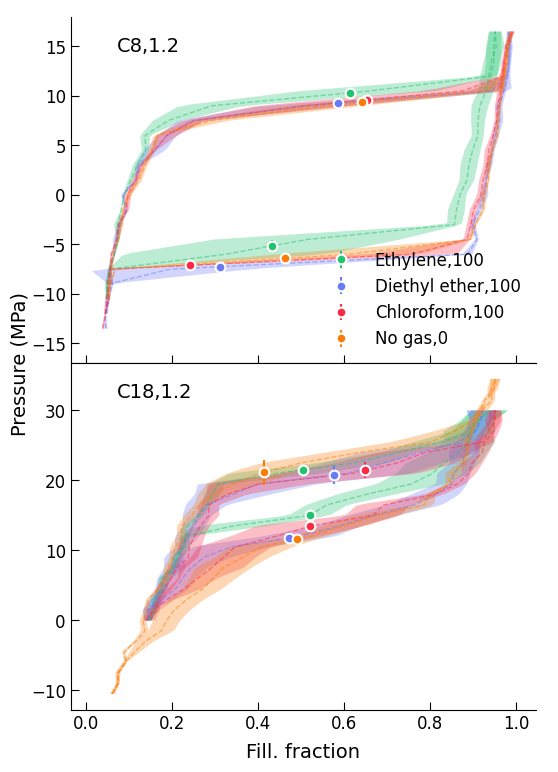

In [36]:
#plot intrusion and extrusion

from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline

def plot_av_cycle(ax,files,color,label,norm=False,cut_down="no",cut_up="no"):
    df = pd.read_csv(f"{files[0]}").reset_index().dropna()
    if cut_up != "no" :
        df = df[df["press"] <= cut_up]
    if cut_down != "no":
        df = df[df["press"] >= cut_down]

    if norm:
        norm_file = files[0].replace("intrusion","extrusion")
        df_norm = pd.read_csv(f"{norm_file}").reset_index()
        
        if cut_up != "no" :
            df_norm = df_norm[df_norm["press"] <= cut_up]
        if cut_down != "no":
            df_norm = df_norm[df_norm["press"] >= cut_down]

        df["mean"] = df["mean"]/df_norm["mean"].max()

    pies = pd.read_csv(f"{files[1]}").reset_index()
    pie_mean, pie_std = pies["press"].mean(), pies["press"].std()/np.sqrt(len(pies))

    df_mean = df[["press","mean"]].groupby("press").mean().reset_index()
    df_mean["std"] = df[["press","mean"]].groupby("press").std().reset_index()["mean"]/np.sqrt(len(df["run"].unique()))
    df_mean = df_mean.dropna()

    x = np.linspace(df_mean["press"].min(),df_mean["press"].max(),100)
    y = make_interp_spline(df_mean["press"],df_mean["mean"],k=1,bc_type=None)   
    ydown = make_interp_spline(df_mean["press"],df_mean["mean"]-df_mean["std"],k=1,bc_type=None)
    yup =  make_interp_spline(df_mean["press"],df_mean["mean"]+df_mean["std"],k=1,bc_type=None) 
    ax.fill_betweenx(x,ydown(x),yup(x), alpha=0.3, color=color, ec="none", fc=color)

    ax.plot(df_mean["mean"],df_mean["press"], lw=1, ls="dashed", color=color, alpha=0.5, zorder=3)    
    ax.errorbar(y(pie_mean), pie_mean, yerr=pie_std, ls="none", marker="o", markersize=7, mec="white", mew=1.5, c=color, mfc=color, label=label, zorder=5)
    return df_mean

colors = {"Chloroform,C8,1.2,100":"xkcd:strawberry","Chloroform,C8,1.2,1000":"xkcd:strawberry","Chloroform,C18,1.2,100":"xkcd:strawberry","Chloroform,C18,1.2,1000":"xkcd:strawberry",
          "Diethyl_ether,C8,1.2,100":"xkcd:cornflower","Diethyl_ether,C18,1.2,100":"xkcd:cornflower", "Diethyl_ether,C8,1.2,1000":"xkcd:cornflower","Diethyl_ether,C18,1.2,1000":"xkcd:cornflower",
          "Ethylene,C8,1.2,100":"xkcd:algae green","Ethylene,C8,1.2,1000":"xkcd:algae green","Ethylene,C18,1.2,100":"xkcd:algae green","Ethylene,C18,1.2,1000":"xkcd:algae green",
          "None,C8,1.2,0":"xkcd:pumpkin orange","None,C18,1.2,0":"xkcd:pumpkin orange"}

fig, axes = plt.subplots(2,1,figsize=(6,9),sharex=True)

systems = ["C8,1.2","C18,1.2"]
mols = ["Ethylene,100","Diethyl_ether,100","Chloroform,100","None,0"]
cycles = ["Cycle2","Cycle2","Cycle2","N1"]

dfs_int = {}
dfs_ext = {}

for mole,cycle in zip(mols,cycles):
    ngas = mole.split(",")[1]
    mol = mole.split(",")[0]
    print(mol)

    for sys,cutDown,cutUp,ax in zip(systems,[-13.5,-13.5],[16.5,30.0],axes):

        c, g = sys.split(',')[0], sys.split(',')[1]
        if mol == "None" and c == "C18":
            cutDown = -13.5
            cutUp = 35
        dfs = {}

        for ie,pie in zip(["intrusion","extrusion"],["pints","pexts"]):

            if mol == "Chloroform" and ngas =="1000" and sys == "C18,1.2":
                continue
            if ie == "intrusion":
                label=f"{mol},{ngas}"
            else:
                label=""

            if ngas == "0":
                extra = "_"
            else:
               extra=f"_{ngas}_"

            file_ie = f"{root}/Int_ext_cycles/{ie}_{mol}_{c}_{g}{extra}{cycle}.dat"
            file_pie = f"{root}/Int_ext_cycles/{pie}_{mol}_{c}_{g}{extra}{cycle}.dat"

            df = plot_av_cycle(ax,[file_ie,file_pie],colors[f"{mol},{c},{g},{ngas}"],label.replace("None","No gas").replace("_"," "),norm=True, cut_down=cutDown, cut_up=cutUp)
            dfs[ie] = df


        #dfs["intrusion"].to_csv(f"{root}/Int_ext_cycles/mean_intrusion_{mol}_{sys}_{cycle}.dat",index=False)
        #dfs["extrusion"].to_csv(f"{root}/Int_ext_cycles/mean_extrusion_{mol}_{sys}_{cycle}.dat",index=False)
        ax.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)

axes[0].legend(frameon=False, handlelength=2.5, fontsize=12, framealpha=0.7, facecolor="white", edgecolor="xkcd:light gray", loc="lower right")  
axes[0].set_ylim(bottom=-17)
axes[0].text(0.1, 0.9, "C8,1.2", ha="left", transform=axes[0].transAxes, fontsize=14)
axes[1].text(0.1, 0.9, "C18,1.2", ha="left", transform=axes[1].transAxes, fontsize=14)

stilyze_plot(fig,"Fill. fraction","Pressure (MPa)",invis=[["top","right"],["right"]])

fig.subplots_adjust(hspace=0)
fig.savefig(f"{root}/plots/Int_ext_cycles_{cycle}_1.png",dpi=350)

In [ ]:
#plot intrusion and extrusion

from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline

def plot_av_cycle(ax,files,color,label,norm=False,cut_down="no",cut_up="no"):
    df = pd.read_csv(f"{files[0]}").reset_index()
    if cut_up != "no" :
        df = df[df["press"] <= cut_up]
    if cut_down != "no":
        df = df[df["press"] >= cut_down]

    if norm:
        norm_file = files[0].replace("intrusion","extrusion")
        df_norm = pd.read_csv(f"{norm_file}").reset_index()
        print(df_norm)
        
        if cut_up != "no" :
            df_norm = df_norm[df_norm["press"] <= cut_up]
        if cut_down != "no":
            df_norm = df_norm[df_norm["press"] >= cut_down]

        df["mean"] = df["mean"]/df_norm["mean"].max()


    pies = pd.read_csv(f"{files[1]}").reset_index()
    pie_mean, pie_std = pies["press"].mean(), pies["press"].std()/np.sqrt(len(pies))

    df_mean = df[["press","mean"]].groupby("press").mean().reset_index()
    df_mean["std"] = df[["press","mean"]].groupby("press").std().reset_index()["mean"]/np.sqrt(len(df["run"].unique()))

    x = np.linspace(df_mean["press"].min(),df_mean["press"].max(),1000)
    y = make_interp_spline(df_mean["press"],df_mean["mean"],k=1,bc_type=None)   
    ydown = make_interp_spline(df_mean["press"],df_mean["mean"]-df_mean["std"],k=1,bc_type=None)
    yup =  make_interp_spline(df_mean["press"],df_mean["mean"]+df_mean["std"],k=1,bc_type=None) 
    ax.fill_between(x,ydown(x),yup(x), alpha=0.3, color=color, ec="none", fc=color)

    ax.plot(df_mean["press"],df_mean["mean"], lw=1, ls="dashed", color=color, alpha=0.5, zorder=3)    
    ax.errorbar(pie_mean, y(pie_mean), xerr=pie_std, ls="none", marker="o", markersize=7, mec="white", mew=1.5, c=color, mfc=color, label=label, zorder=5)
    return df_mean

colors = {"Chloroform,C8,1.2,100":"xkcd:strawberry","Chloroform,C8,1.2,1000":"xkcd:raspberry","Chloroform,C18,1.2,100":"xkcd:strawberry","Chloroform,C18,1.2,1000":"xkcd:raspberry",
          "Ethylene,C8,1.2,100":"xkcd:mid blue","Ethylene,C18,1.2,100":"xkcd:mid blue",
          "Diethyl_ether,C8,1.2,100":"xkcd:algae green","Diethyl_ether,C8,1.2,1000":"xkcd:teal","Diethyl_ether,C18,1.2,100":"xkcd:algae","Diethyl_ether,C18,1.2,1000":"xkcd:teal",
          "None,C8,1.2,0":"xkcd:pumpkin orange","None,C18,1.2,0":"xkcd:pumpkin orange"}

fig, ax = plt.subplots()

systems = ["C18,1.2"]
mols = ["Ethylene,100","Diethyl_ether,1000","None,0"]
cycles = ["Cycle2","Cycle2","N1"]

dfs_int = {}
dfs_ext = {}

for mole,cycle in zip(mols,cycles):
    ngas = mole.split(",")[1]
    mol = mole.split(",")[0]

    for sys,cutDown,cutUp in zip(systems,[-13.5],[35]):

        c, g = sys.split(',')[0], sys.split(',')[1]
        if mol == "None" and c == "C18":
            cutDown = -13.5
            cutUp = 35
        dfs = {}

        for ie,pie in zip(["intrusion","extrusion"],["pints","pexts"]):

            if ie == "extrusion":
                label=f"{mol}"
            else:
                label=""

            if ngas == "0":
                extra = "_"
            else:
               extra=f"_{ngas}_"

            file_ie = f"{root}/Int_ext_cycles/{ie}_{mol}_{c}_{g}{extra}{cycle}.dat"
            file_pie = f"{root}/Int_ext_cycles/{pie}_{mol}_{c}_{g}{extra}{cycle}.dat"

            try:
                df = plot_av_cycle(ax,[file_ie,file_pie],colors[f"{mol},{c},{g},{ngas}"],label.replace("None","No gas").replace("_"," "),norm=True, cut_down=cutDown, cut_up=cutUp)
                dfs[ie] = df
            except Exception as err:
                print(err)
                continue

        #dfs["intrusion"].to_csv(f"{root}/Int_ext_cycles/mean_intrusion_{mol}_{sys}_{cycle}.dat",index=False)
        #dfs["extrusion"].to_csv(f"{root}/Int_ext_cycles/mean_extrusion_{mol}_{sys}_{cycle}.dat",index=False)
        ax.tick_params(which='major', length=6, direction="in", top=False, bottom=True, left=True, right=False, labelsize=12)

    ax.legend(frameon=True, handlelength=2.5, fontsize=12, framealpha=0.7, facecolor="white", edgecolor="xkcd:light gray", loc="lower right")  
    #axes[0].set_ylim(bottom=-17)
    ax.text(0.05, 0.95, "C18, 1.2 gps/nm$^2$", ha="left", transform=ax.transAxes, fontsize=14)

    stilyze_plot(fig,"Pressure (MPa)","Fill. fraction",invis=[["top","right"]])

    fig.subplots_adjust(hspace=0)
    fig.savefig(f"{root}/plots/Int_ext_cycles_{sys}.png",dpi=350)

# Gas count

In [ ]:
# gas count in time

from matplotlib.lines import Line2D

def save(time,press,gas_count,water_count,root,mol,sys,run,ngas):
    df = pd.DataFrame({"t":time, "press":press, "n":gas_count, "nw":water_count})
    df["run"] = run
    df["sys"] = sys
    df.to_csv(f"{root}/outfiles/gas_count_{mol}_{sys}_{ngas}_{run}_{cycle}.dat", index=False)

runs = ["eq"] 
ngas = 100
systems = ["Chloroform,C18,1.2"]
cycles = ["Cycle2"]

for system in systems:
    mol,sys = system.split(",")[0], ",".join(system.split(",")[1:])
    
    for run in runs:
        for cycle in cycles:
            print(system,cycle)

            Ps = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/intrusion/*MPa"))
            Ps = [p for p in Ps if float(p.split("MPa")[0].split("/")[-1].replace("neg","-")) <= 30]

            i = 0
            while i < len(Ps):
                p = Ps[i]
                gro = natsort.natsorted(glob(f"{p}/*part*.gro"))
                if gro != []:
                    Ps = Ps[i:]
                    u0 = mda.Universe(gro[-1])
                    break
                else:
                    i += 1

            bulk = u0.select_atoms("resname BULK")
            zmin, zmax = np.min(bulk.positions[:,2]), np.max(bulk.positions[:,2])
            gas = u0.select_atoms(f"resname CLF or resname ETY and prop z >= {zmin} and prop z <= {zmax}", updating=True)
            gas_tot = u0.select_atoms("resname CLF or resname ETY or resname ETH").n_atoms
            w_tot = u0.select_atoms("resname W or resname SW or resname TW").n_atoms
            C = 0.006
            print("number concentration (n_gas/nm^3): ",C)
            gas_count = []
            water_count = []
            time = []
            t = 0
            pressures = []
            
            for ie,rev in zip(["intrusion","extrusion"],[False,True]):
                Ps = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/{ie}/*MPa"))
                press_list = [float(p.split("/")[-1].replace("neg","-").split("MPa")[0]) for p in Ps]

                for press,p in tqdm(sorted(zip(press_list,Ps), reverse=rev)):
                    gro = natsort.natsorted(glob(f"{p}/*part*.gro"))
                    try:
                        u = mda.Universe(gro[-1])
                    except:
                        continue
                    
                    time.append(t)
                    gas = u.select_atoms(f"resname CLF or resname ETY or resname ETH and prop z >= {zmin} and prop z <= {zmax}")
                    water = u.select_atoms(f"resname W or resname SW or resname TW and prop z >= {zmin} and prop z <= {zmax}")
                    gas_count.append(gas.n_atoms/gas_tot)
                    water_count.append(water.n_atoms/w_tot)
                    pressures.append(press) 
                    t += 10000

                save(time,pressures,gas_count,water_count,root,mol,sys,run,ngas)

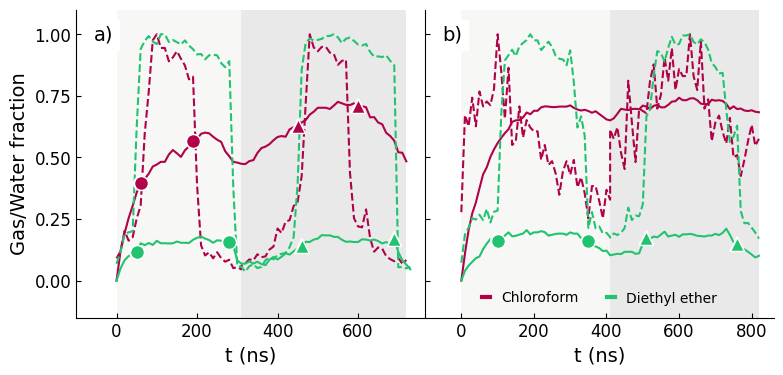

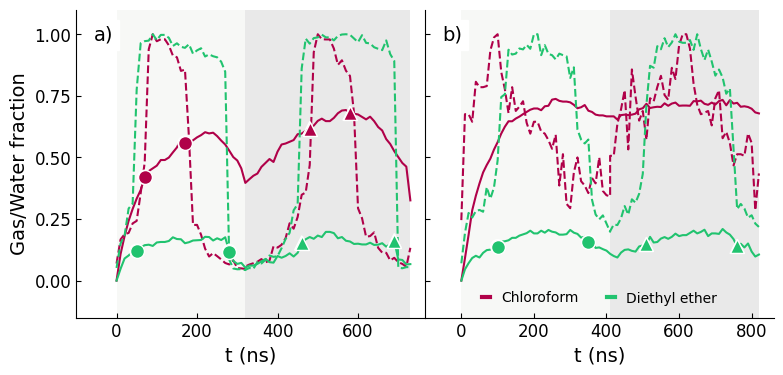

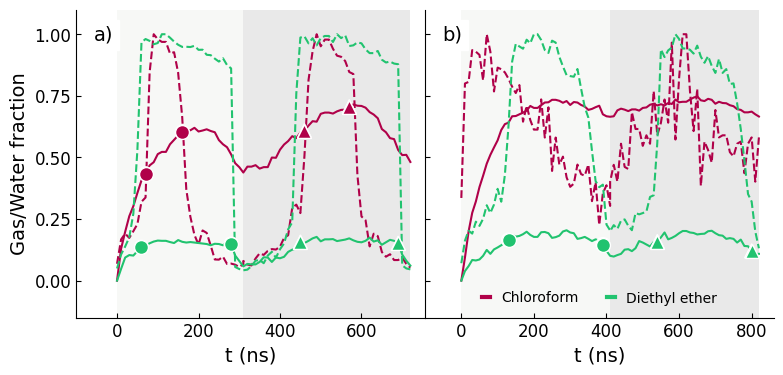

In [11]:
#plot gas count for each run

from scipy.interpolate import make_interp_spline
from matplotlib.lines import Line2D


def closest_number(numbers):
    closest_num = None
    closest_diff = float('inf')
    for num in numbers:
        if num % 1.5 == 0:
            return num
        diff = abs(num - 1.5 * round(num / 1.5))
        if diff < closest_diff:
            closest_num = num
            closest_diff = diff
    return 1.5 * round(closest_num / 1.5)

runs = ["eq","eq2","eq3"] 
ngas = 1000
cycles = ["Cycle1","Cycle2"]
markers = {"Cycle1":"o","Cycle2":"^"}
mols = ["Chloroform","Diethyl_ether"]
systs = ["C8,1.2","C18,1.2"]
systems = [[f"{mol},{sys}" for mol in mols] for sys in systs ]
colors_back = {"Cycle1":"xkcd:light grey","Cycle2":"xkcd:grey"}
lines = {"eq":{}, "eq2":{}, "eq3":{}}
pis = {"eq":{}, "eq2":{}, "eq3":{}}
pes = {"eq":{}, "eq2":{}, "eq3":{}}
ticklabs = []
ticklabs_real = []

for run in runs:
    fig,axes = plt.subplots(1,2, figsize=(9,4), sharey=True)

    for ax,ss in zip(axes,systems):
        for system in ss:
            info = system.split(",")
            mol,sys,c,g = info[0], ",".join(info[1:]), info[1], info[2]

            tlast = 0
            lines[run][system] = {"t":[],"n":[],"nw":[]}
            pis[run][system] = {"t":[],"n":[]}
            pes[run][system] = {"t":[],"n":[]}

            for cycle in cycles:
                pints = pd.read_csv(f"{root}/Int_ext_cycles/pints_{mol}_{c}_{g}_{ngas}_{cycle}.dat")
                pexts = pd.read_csv(f"{root}/Int_ext_cycles/pexts_{mol}_{c}_{g}_{ngas}_{cycle}.dat")

                xint, xext = {}, {}
                df = pd.read_csv(f"{root}/outfiles/gas_count_{mol}_{sys}_{ngas}_{run}_{cycle}.dat")

                Pint = pints[pints["run"]==run]["press"].values[0]
                Pext = pexts[pexts["run"]==run]["press"].values[0]

                df["t"] = df["t"]/1000+tlast
                df["nw"] = df["nw"]/df["nw"].max()

                idx = df["press"].idxmax()
                tint = df.iloc[:idx+1].reset_index(drop=True)
                text = df.iloc[idx+1:].reset_index(drop=True)

                dfint = tint[tint["press"]==closest_number([Pint])]
                dfext = text[text["press"]==closest_number([Pext])]

                try:
                    xint[run] = dfint["t"].values[0]
                    xext[run] = dfext["t"].values[0]
                except:
                    continue

                if not (c == "C18" and mol == "Chloroform" and ngas == 1000):   
                    ax.scatter(dfint["t"], dfint["n"], s=100, color=colors[system], marker=markers[cycle], ec='white', fc="none", zorder=3)
                    ax.scatter(dfint["t"], dfint["n"], s=100, color=colors[system], marker=markers[cycle], ec='white', fc=colors[system], zorder=3, alpha=1)
                    ax.scatter(dfext["t"], dfext["n"], s=100, color=colors[system], marker=markers[cycle], ec='white', fc="none", zorder=3)
                    im = ax.scatter(dfext["t"], dfext["n"], s=100, color=colors[system], marker=markers[cycle], ec='white', fc=colors[system], zorder=3, alpha=1)

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_xlabel("t (ns)", size=14)

                if mol == "Chloroform":
                    ax.fill_betweenx(y=[-1,1.2], x1=tlast, x2=df["t"].max(), edgecolor="none", facecolor=colors_back[cycle], alpha=0.2, zorder=-1)

                tlast = df["t"].max()

                lines[run][system]["t"].extend(df["t"].values)
                lines[run][system]["n"].extend(df["n"].values)
                lines[run][system]["nw"].extend(df["nw"].values)

                pis[run][system]["t"].append(dfint["t"].values[0])
                pis[run][system]["n"].append(dfint["n"].values[0])
                pes[run][system]["t"].append(dfext["t"].values[0])
                pes[run][system]["n"].append(dfext["n"].values[0])

            ax.plot(lines[run][system]["t"], lines[run][system]["n"], color=colors[system])
            ax.plot(lines[run][system]["t"], lines[run][system]["nw"], color=colors[system], ls="dashed")
    hs =  [item for sublist in systems for item in sublist]     
    labels = [item.split(",")[0].replace("_"," ") for sublist in systems for item in sublist]
    handles = [Line2D([0],[0],ls="solid", lw=3, c=colors[system]) for system in hs]
    axes[1].legend(handles=handles[len(systems[0]):], labels=labels[len(systems[0]):], ncols=2, frameon=False, loc="lower center", handlelength=0.6, fontsize=10, framealpha=1, markerscale=2, facecolor="white", edgecolor="xkcd:light grey")
    axes[0].set_ylim(-0.15,1.1)
    axes[0].set_xlim(left=-100)
    axes[1].set_xlim(left=-100)
    axes[0].set_yticks([0,0.25,0.5,0.75,1.0])
    axes[0].set_ylabel("Gas/Water fraction", size=14)
    axes[0].tick_params(axis='both', which='major', direction='in')
    axes[1].tick_params(axis='both', which='major', direction='in')
    axes[0].text(0.05, 0.9, "a)", ha="left", transform=axes[0].transAxes, zorder=3, size=14, bbox={"facecolor":"white", "edgecolor":"white","alpha":1})
    axes[1].text(0.05, 0.9, "b)", ha="left", transform=axes[1].transAxes, zorder=3, size=14, bbox={"facecolor":"white", "edgecolor":"white","alpha":1})

    fig.subplots_adjust(wspace=0)
    fig.savefig(f"{root}/plots/gas_count_{run}_{ngas}.png", dpi=350)


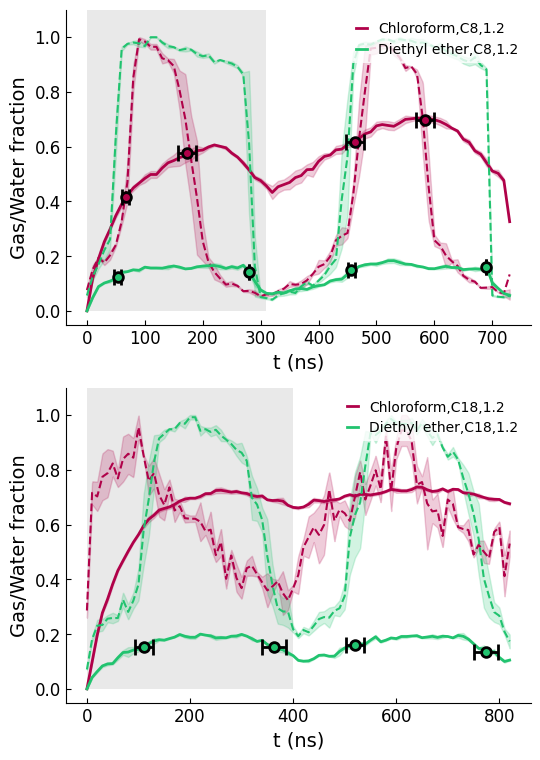

In [12]:
#plot average gas count
x = {"C8":[0,310], "C18":[0,400]}

fig,axes = plt.subplots(2,1,figsize=(6,9))

for s,ax in zip(systems,axes):
    i=0
    for sys in s:
        mol,c,g = sys.split(",")[0],sys.split(",")[1],sys.split(",")[2]
        df = pd.DataFrame()
        df_pi = pd.DataFrame()
        df_pe = pd.DataFrame()

        for run in runs:
            df_t = pd.DataFrame(lines[run][sys] | {"run":[run]*len(lines[run][sys]["t"])})
            pi_t = pd.DataFrame(pis[run][sys] | {"run":[run]*len(pis[run][sys]["t"])})
            pe_t = pd.DataFrame(pes[run][sys] | {"run":[run]*len(pes[run][sys]["t"])})

            df = pd.concat([df,df_t])
            df_pi = pd.concat([df_pi,pi_t])
            df_pe = pd.concat([df_pe,pe_t])

        mean = df[["t","n","nw"]].groupby("t").mean().reset_index()
        std = df[["t","n","nw"]].groupby("t").std().reset_index()/np.sqrt(len(runs))
        pi_mean = df_pi[["t","n"]].groupby(df_pi.index).mean().reset_index()    
        pi_std = df_pi[["t","n"]].groupby(df_pi.index).std().reset_index()

        pe_mean = df_pe[["t","n"]].groupby(df_pe.index).mean().reset_index()
        pe_std = df_pe[["t","n"]].groupby(df_pe.index).std().reset_index()

        ax.plot(mean["t"],mean["n"], c=colors[sys], label=sys.replace("_"," "), lw=2)  
        ax.plot(mean["t"],mean["nw"], c=colors[sys], ls="dashed")
        ax.fill_between(mean["t"],mean["n"]-std["n"],mean["n"]+std["n"], alpha=0.2, color=colors[sys])

        time = np.linspace(mean["t"].min(),mean["t"].max(),1000)
        mean["up"] = mean["nw"]+std["nw"]
        mean["down"] = mean["nw"]-std["nw"]
        mean = mean.dropna()

        ydown = make_interp_spline(mean["t"], mean["down"], k=1, bc_type=None)
        yup =  make_interp_spline(mean["t"], mean["up"], k=1, bc_type=None) 
        ax.fill_between(time, yup(time), ydown(time), alpha=0.2, color=colors[sys])

        if not (c == "C18" and mol == "Chloroform" and ngas == 1000):
            ax.errorbar(pi_mean["t"],pi_mean["n"],xerr=pi_std["t"], ls="none", marker="o", c="k", mec="k", mfc=colors[sys], markeredgewidth=2, markersize=7, elinewidth=2, capsize=6, capthick=2, zorder=5)
            ax.errorbar(pe_mean["t"],pe_mean["n"],xerr=pe_std["t"], ls="none", marker="o", c="k", mec="k", mfc=colors[sys], markeredgewidth=2, markersize=7, elinewidth=2, capsize=6, capthick=2, zorder=5)
        
        if "Diethyl" in sys:
            ax.fill_betweenx(y=[0,1.1], x1=x[c][0], x2=x[c][1], edgecolor="none", facecolor=colors_back[cycle], alpha=0.2, zorder=-1)

        ax.legend(frameon=True, loc="upper right", handlelength=0.8, fontsize=10, framealpha=0.8, facecolor="white", edgecolor="none")
        ax.set_xlabel("t (ns)", size=14)
        ax.set_ylabel("Gas/Water fraction", size=14)
        ax.set_ylim(top=1.1)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', direction='in')
        i+=2

fig.subplots_adjust(hspace=0.2)
fig.savefig(f"{root}/plots/gas_count_average_{ngas}.png", dpi=350)


# Densities

In [ ]:
#radial density

from scipy.interpolate import make_interp_spline
def r_bins(A=10*np.pi,maxR=25):
    R = 0
    bins = []
    while R**2 < maxR**2:
        R_new = np.sqrt(A/np.pi + R**2)
        bins.append(R_new)
        R = R_new
    return (bins)

root="/scratch/project_465000467/FABIO/Anesthetics"

colors = {"Chloroform,C8,1.2":"xkcd:raspberry","Chloroform,C18,1.2":"xkcd:raspberry",
          "Ethylene,C8,1.2":"xkcd:mid blue","Ethylene,C18,1.2":"xkcd:mid blue",
          "Diethyl_ether,C8,1.2":"xkcd:algae green","Diethyl_ether,C18,1.2":"xkcd:algae green",
          "None,C8,1.2":"xkcd:pumpkin orange","None,C18,1.2":"xkcd:pumpkin orange"}

runs = ["eq","eq2","eq3"]
ngas = 100
cycles = ["Cycle1","Cycle2"]
mols = ["Chloroform","Diethyl_ether"]
systs = ["C8,1.2","C18,1.2"]
systems = [[f"{mol},{sys}" for mol in mols] for sys in systs ]
kde_gas = {}
kde_sil = {}

for system in systems:
    for ss in system:
        mol,sys = ss.split(",")[0], ",".join(ss.split(",")[1:])
        print(mol,sys)

        for run in runs:
            for cycle in cycles:

                for ie,rev in zip(["intrusion","extrusion"],[False,True]):
                    Ps = natsort.natsorted(glob(f"{root}/{mol}/{sys}/{ngas}/{run}/{cycle}/{ie}/*MPa"))
                    press_list = [float(p.split("/")[-1].replace("neg","-").split("MPa")[0]) for p in Ps]
                    
                    for press,p in tqdm(sorted(zip(press_list,Ps), reverse=rev)):
                        gro = natsort.natsorted(glob(f"{p}/*part*.gro"))
                        try:
                            u = mda.Universe(gro[-1])
                        except:
                            continue

                            
                        lay = u.select_atoms("resname LAY")
                        zmin, zmax = np.min(lay.positions[:,2]), np.max(lay.positions[:,2]) 
                        gas = u.select_atoms(f"resname CLF or resname ETY or resname ETH and prop z >= {zmin} and prop z <= {zmax}", updating=True)
                        sil = u.select_atoms(f"resname SIL and prop z >= {zmin} and prop z <= {zmax}", updating=True)   
                        com = lay.center_of_mass()
                        
                        kde_gas[sys] = []
                        kde_sil[sys] = []
                        for ts in u.trajectory[:]:     
                            pos_gas = gas.positions
                            pos_sil = sil.positions

                            x_gas = pos_gas[:,0] - com[0]
                            y_gas = pos_gas[:,1] - com[1]
                            x_sil = pos_sil[:,0] - com[0]
                            y_sil = pos_sil[:,1] - com[1]

                            kde_gas[sys].extend(np.sqrt(x_gas**2 + y_gas**2))
                            kde_sil[sys].extend(np.sqrt(x_sil**2 + y_sil**2))

                        df_gas = pd.DataFrame({"gas": kde_gas[sys]})
                        df_gas.to_csv(f"{root}/outfiles/kdes/kde_gas_{mol}_{sys}_{ngas}_{run}_{cycle}_{press}.dat", index=False)
                        df_sil = pd.DataFrame({"sil": kde_sil[sys]})
                        df_sil.to_csv(f"{root}/outfiles/kdes/kde_sil_{mol}_{sys}_{ngas}_{run}_{cycle}_{press}.dat", index=False)


4937
50234
5961
29440
6476
49281
7493
61615
4859
21658
6124
30048


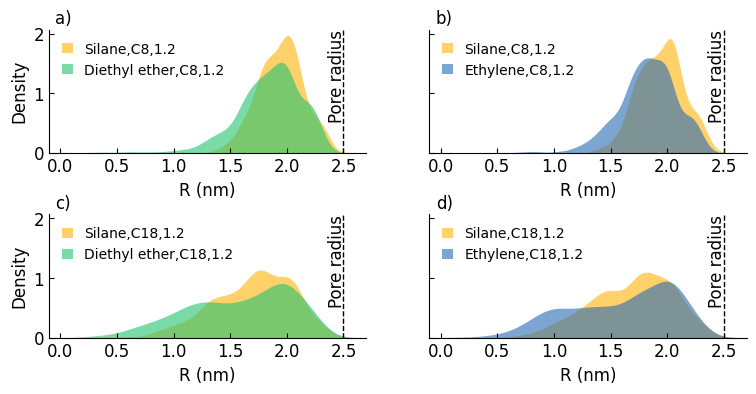

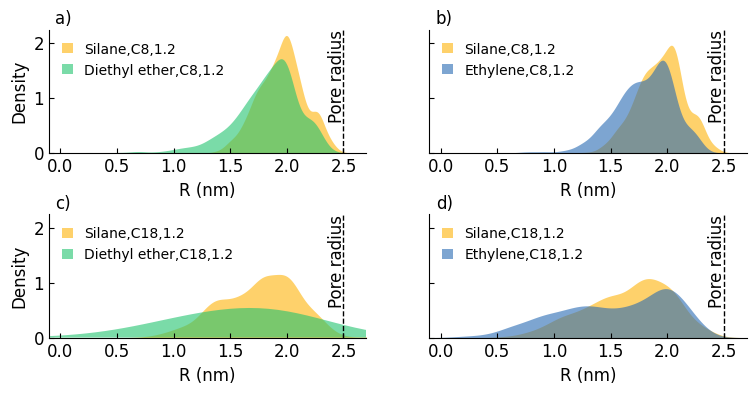

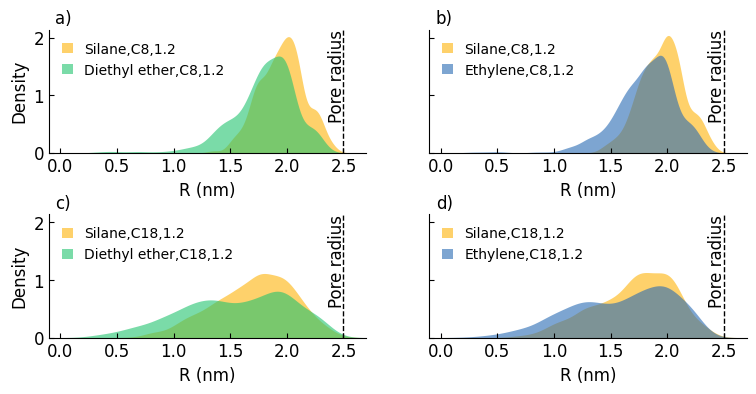

In [45]:
#plot density



import seaborn as sns

systems = ["Diethyl_ether,C8,1.2","Ethylene,C8,1.2","Diethyl_ether,C18,1.2","Ethylene,C18,1.2"]
runs = ["eq","eq2","eq3"]
cycle = "Cycle2"
ngas = 100

for run in runs:
    fig,axes = plt.subplots(2,2, figsize=(9,4), sharey=True)
    axes = axes.flatten("C")
    
    for ax,system,letter in zip(axes,systems,["a","b","c","d"]):
        mol,sys = system.split(",")[0], ",".join(system.split(",")[1:])
        df_gas = pd.read_csv(f"{root}/outfiles/kde_gas_{system}_{ngas}_{run}_{cycle}.dat")
        df_sil= pd.read_csv(f"{root}/outfiles/kde_sil_{system}_{ngas}_{run}_{cycle}.dat")

        print(len(df_gas))

        sns.kdeplot(x=df_sil["sil"][:1000]*.1, bw_adjust=1, label=f"Silane,{sys}", ax=ax, color="xkcd:amber", fill=True, alpha=.6, linewidth=0)
        sns.kdeplot(x=df_gas.loc[:1000,"gas"]*.1, bw_adjust=1,label=system.replace("_"," "), ax=ax, color=colors[system], fill=True, alpha=.6, linewidth=0)
    
        ax.text(0.02, 1.05, f"{letter})", ha="left", transform=ax.transAxes, zorder=1, size=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', direction='in')
        ax.set_xlabel("R (nm)", size=12)
        ax.axvline(2.5, ls='--', color="black", lw=1)
        ax.text(0.88, 1, "Pore radius", rotation=90, ha="left", va="top", transform=ax.transAxes, zorder=1, size=12)
        ax.set_xlim(-0.1,2.7)

        ax.legend(frameon=True, handlelength=0.8, fontsize=10, framealpha=1, facecolor="white", edgecolor="white")

    fig.subplots_adjust(hspace=0.5)
    fig.savefig(f"{root}/plots/kde_gas_sil_{cycle}_{run}.png", dpi=350)

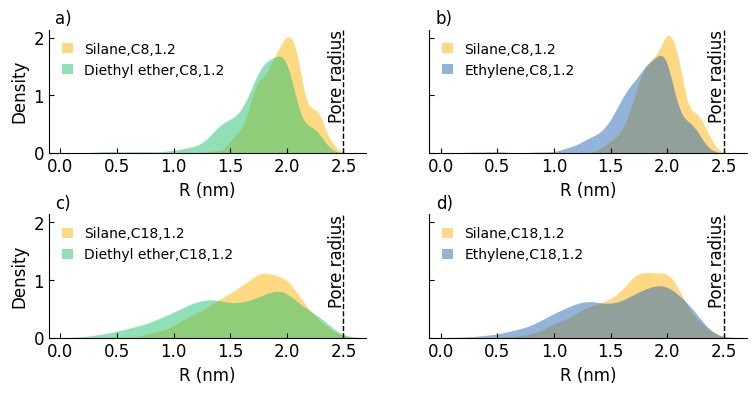

In [49]:
#plot density average

import seaborn as sns

root="/scratch/project_465000467/FABIO/Anesthetics"

systems = ["Diethyl_ether,C8,1.2","Ethylene,C8,1.2","Diethyl_ether,C18,1.2","Ethylene,C18,1.2"]
runs = ["eq","eq2","eq3"]
cycle = "Cycle2"
ngas = 100

fig,axes = plt.subplots(2,2, figsize=(9,4), sharey=True)
axes = axes.flatten("C")

for ax,system,letter in zip(axes,systems,["a","b","c","d"]):
    df_sils = pd.DataFrame()
    df_gases = pd.DataFrame()

    for run in runs:
        mol,sys = system.split(",")[0], ",".join(system.split(",")[1:])
        df_gas = pd.read_csv(f"{root}/outfiles/kde_gas_{system}_{ngas}_{run}_{cycle}.dat")
        df_sil = pd.read_csv(f"{root}/outfiles/kde_sil_{system}_{ngas}_{run}_{cycle}.dat")

        
        df_gases = pd.concat([df_gases.loc,df_gas])
        df_sils = pd.concat([df_sils,df_sil])

    #df_av_gas = df_gases.groupby(df_gases.index).mean().reset_index()
    #df_av_sil = df_sils.groupby(df_sils.index).mean().reset_index()
    sns.kdeplot(x=df_sil.loc[:,"sil"]*.1, bw_adjust=1, label=f"Silane,{sys}", ax=ax, color="xkcd:amber", fill=True, alpha=.5, linewidth=0)
    sns.kdeplot(x=df_gas.loc[:,"gas"]*.1, bw_adjust=1,label=system.replace("_"," "), ax=ax, color=colors[system], fill=True, alpha=.5, linewidth=0)
    

    ax.text(0.02, 1.05, f"{letter})", ha="left", transform=ax.transAxes, zorder=1, size=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', direction='in')
    ax.set_xlabel("R (nm)", size=12)
    ax.axvline(2.5, ls='--', color="black", lw=1)
    ax.text(0.88, 1, "Pore radius", rotation=90, ha="left", va="top", transform=ax.transAxes, zorder=1, size=12)
    ax.set_xlim(-0.1,2.7)

    ax.legend(frameon=True, handlelength=0.8, fontsize=10, framealpha=1, facecolor="white", edgecolor="white")

fig.subplots_adjust(hspace=0.5)
fig.savefig(f"{root}/plots/kde_gas_sil_{cycle}_average.svg", dpi=350)